## Plan of Action


1.   Load **IMDb Movie Reviews dataset (50,000 reviews)**
2.   **Pre-process dataset** by removing special characters, numbers, etc. from user reviews + convert **sentiment labels** positive & negative to numbers 1 & 0, respectively
3.   **Import GloVe Word Embedding** to build Embedding Dictionary + Use this to build Embedding Matrix for our Corpus
4. Model Training using **Deep Learning in Keras** for separate: **Simple Neural Net, CNN and LSTM Models** and analyse model performance and results
4. Last, perform **predictions on real IMDb movie reviews**

## Setting the environment

In [4]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [6]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [11]:
from keras.utils import pad_sequences

## Loading dataset

In [12]:
# Importing IMDb Movie Reviews dataset

movie_reviews = data = pd.read_csv('../../Data/a1_IMDB_Dataset.csv')

# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [13]:
# Dataset exploration

movie_reviews.shape

(50000, 2)

In [14]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
# Checking for missing values

movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

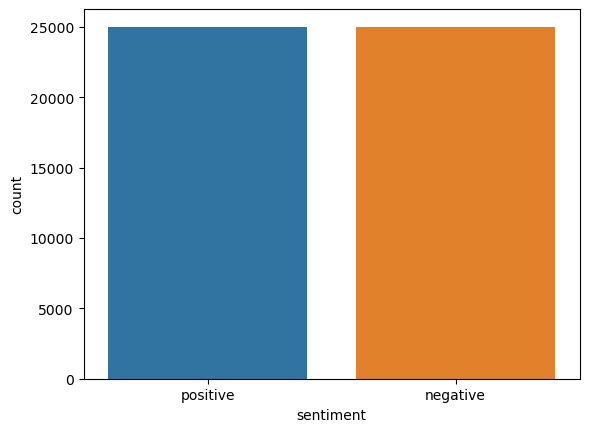

In [16]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [19]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers 
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [9]:
# import b2_preprocessing_function
from b2_preprocessing_function import CustomPreprocess

In [10]:
custom = CustomPreprocess()
custom.preprocess_text("Those were the best days of my life!")

'best days life '

In [20]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sen = sen.lower()
    
    # Remove html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(set(stopwords.words('english'))) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    
    return sentence

In [22]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [23]:
# Sample cleaned up movie review 

X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [24]:
# Converting sentiment labels to 0 & 1

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [40]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [39]:
print(len(X_train[2]))
print(len(preprocess_text(X[2]).split()))

281
84


In [41]:
import io
import json

In [42]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [43]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

91882

In [44]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [49]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../../Data/Vectors/glove.6B.200d.txt', encoding="utf8")##çok yer kaladığı için projeden sildim. siz tekrar indirebilirsiniz.

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [50]:
# Create Embedding Matrix having 200 columns 
# Containing 200-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 200))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [51]:
embedding_matrix.shape

(91882, 200)

# Model Training with:

## Simple Neural Network

In [52]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [53]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          18376400  
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 18,396,401
Trainable params: 20,001
Non-trainable params: 18,376,400
_________________________________________________________________
None


In [54]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6


2023-05-15 12:20:40.002750: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 1s 3ms/step - loss: 0.5163 - acc: 0.7447 - val_loss: 0.4677 - val_acc: 0.7810
Epoch 2/6
250/250 [==============================] - 1s 2ms/step - loss: 0.3733 - acc: 0.8404 - val_loss: 0.4706 - val_acc: 0.7840
Epoch 3/6
250/250 [==============================] - 1s 2ms/step - loss: 0.3254 - acc: 0.8656 - val_loss: 0.4968 - val_acc: 0.7710
Epoch 4/6
250/250 [==============================] - 1s 2ms/step - loss: 0.2925 - acc: 0.8826 - val_loss: 0.5123 - val_acc: 0.7759
Epoch 5/6
250/250 [==============================] - 1s 2ms/step - loss: 0.2689 - acc: 0.8935 - val_loss: 0.5310 - val_acc: 0.7746
Epoch 6/6
250/250 [==============================] - 1s 2ms/step - loss: 0.2487 - acc: 0.9050 - val_loss: 0.5573 - val_acc: 0.7714


In [55]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 0s 647us/step - loss: 0.5487 - acc: 0.7700


### Mini Homework!!

Metni işleme yaklaşımını değiştirerek *opsiyonel
Daha büyük bir glove vektörü,
Farklı embedding boyutları
Daha fazla katman ile 

yeniden model eğitin. Değişen sonuçları yorumlayın.

In [56]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5487167835235596
Test Accuracy: 0.7699999809265137


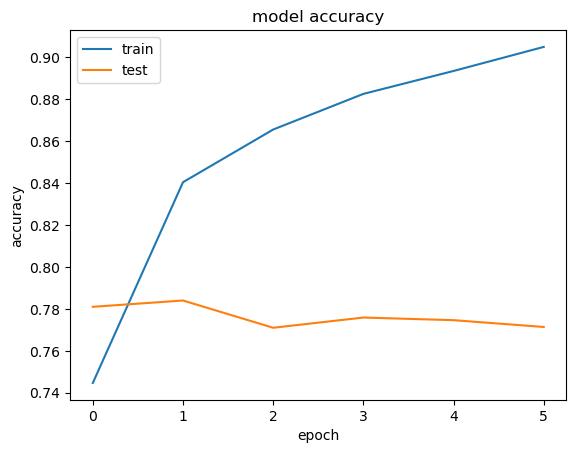

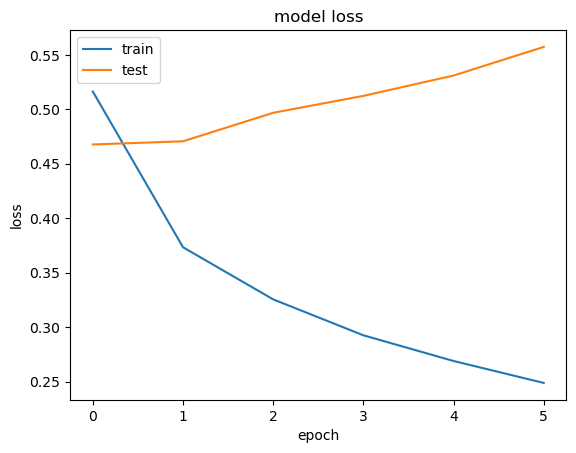

In [57]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [58]:
from keras.layers import Conv1D

In [61]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [62]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 200)          18376400  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,504,657
Trainable params: 128,257
Non-trainable params: 18,376,400
_________________________________________________________________
None


In [63]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 9s 34ms/step - loss: 0.4237 - acc: 0.8050 - val_loss: 0.3490 - val_acc: 0.8471
Epoch 2/6
250/250 [==============================] - 8s 34ms/step - loss: 0.2931 - acc: 0.8789 - val_loss: 0.3609 - val_acc: 0.8403
Epoch 3/6
250/250 [==============================] - 8s 33ms/step - loss: 0.2284 - acc: 0.9153 - val_loss: 0.3210 - val_acc: 0.8604
Epoch 4/6
250/250 [==============================] - 8s 33ms/step - loss: 0.1721 - acc: 0.9461 - val_loss: 0.3508 - val_acc: 0.8455
Epoch 5/6
250/250 [==============================] - 9s 35ms/step - loss: 0.1220 - acc: 0.9715 - val_loss: 0.3263 - val_acc: 0.8595
Epoch 6/6
250/250 [==============================] - 8s 32ms/step - loss: 0.0827 - acc: 0.9893 - val_loss: 0.3315 - val_acc: 0.8618


In [64]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.3337 - acc: 0.8649


In [65]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.33366474509239197
Test Accuracy: 0.8648999929428101


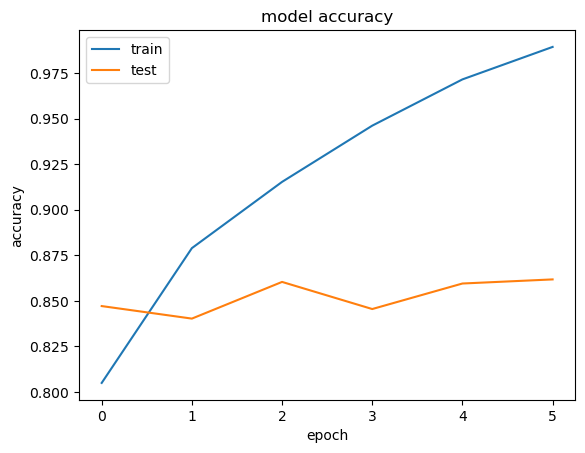

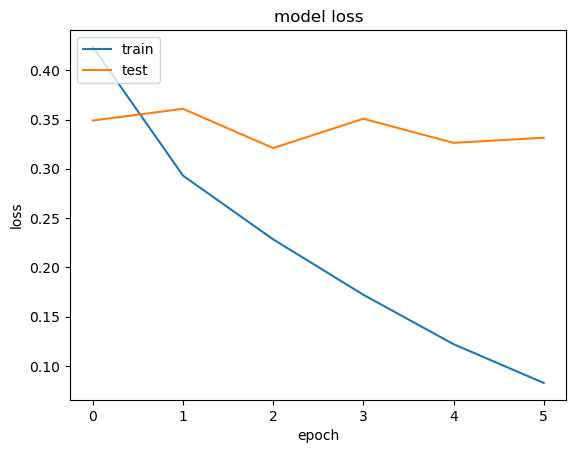

In [66]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network (LSTM)

In [67]:
from keras.layers import LSTM

In [94]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 200, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [95]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 200)          18376400  
                                                                 
 lstm_1 (LSTM)               (None, 128)               168448    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,544,977
Trainable params: 168,577
Non-trainable params: 18,376,400
_________________________________________________________________
None


In [70]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 41s 161ms/step - loss: 0.4723 - acc: 0.7774 - val_loss: 0.4180 - val_acc: 0.8201
Epoch 2/6
250/250 [==============================] - 43s 173ms/step - loss: 0.3777 - acc: 0.8377 - val_loss: 0.3585 - val_acc: 0.8391
Epoch 3/6
250/250 [==============================] - 44s 177ms/step - loss: 0.3369 - acc: 0.8573 - val_loss: 0.3278 - val_acc: 0.8581
Epoch 4/6
250/250 [==============================] - 45s 180ms/step - loss: 0.3106 - acc: 0.8704 - val_loss: 0.3240 - val_acc: 0.8535
Epoch 5/6
250/250 [==============================] - 44s 177ms/step - loss: 0.2940 - acc: 0.8793 - val_loss: 0.3403 - val_acc: 0.8526
Epoch 6/6
250/250 [==============================] - 47s 187ms/step - loss: 0.2664 - acc: 0.8931 - val_loss: 0.3012 - val_acc: 0.8751


In [71]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 10s 32ms/step - loss: 0.3051 - acc: 0.8751


In [72]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3051183223724365
Test Accuracy: 0.8751000165939331


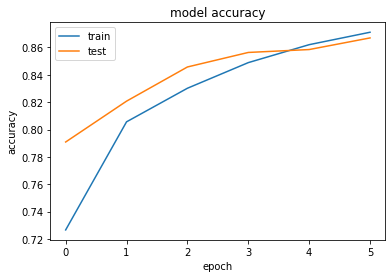

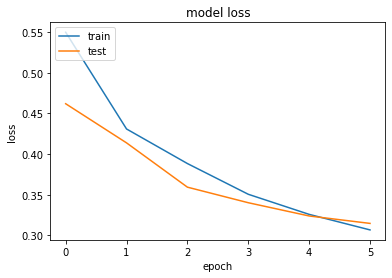

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [73]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"../../Data/Vectors/LearnedFromExercises/c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [74]:
pwd # lists files in working directory

'/Users/kemalcankara/Desktop/ders_icerik_2023/Codes/anlp2023/Codes/5.Sequence_Modeling'

In [76]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='../../Data/Vectors/LearnedFromExercises/c1_lstm_model_acc_0.875.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 200)          18376400  
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18,544,977
Trainable params: 168,577
Non-trainable params: 18,376,400
_________________________________________________________________


In [77]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("../../Data/a2_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [79]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review =preprocess_text(review)
  unseen_processed.append(review)

In [80]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [82]:
from keras.preprocessing.text import tokenizer_from_json


In [83]:
# Loading
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [84]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [85]:
unseen_tokenized

[[953,
  1,
  1,
  396,
  13920,
  1266,
  636,
  15554,
  1229,
  7070,
  523,
  1540,
  99,
  1766,
  1466,
  1,
  3697,
  16,
  4,
  26,
  140,
  21405,
  720,
  2128,
  1206,
  15554,
  17,
  10724,
  202,
  648,
  7755,
  75,
  10204,
  1453,
  4819,
  1491,
  7345,
  4819,
  1962,
  8829,
  8101,
  1034,
  36,
  84,
  468,
  440,
  881,
  1741,
  268,
  1460,
  150,
  650,
  3,
  1380,
  1297,
  3,
  63,
  1,
  780,
  4236,
  5614,
  1835,
  188,
  780,
  51,
  846,
  13,
  82,
  10,
  16,
  3920,
  1,
  574,
  1906,
  1403,
  93,
  115,
  990,
  24,
  260,
  1,
  2615,
  63,
  990,
  1,
  15554,
  25296,
  26,
  314,
  1009,
  116,
  1922,
  732,
  1,
  15554,
  1818,
  1,
  314,
  3709,
  17,
  384,
  3709,
  572,
  1,
  3885,
  24,
  287,
  162,
  615,
  15554,
  262,
  1,
  12610,
  84,
  4888,
  294,
  1818,
  1,
  1026,
  215,
  280,
  1368,
  1111,
  15466,
  3709,
  906,
  18,
  151,
  325,
  1250,
  1,
  1846,
  282,
  1644,
  13920,
  1,
  3162,
  1,
  125,
  648,
  140

In [86]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [87]:
unseen_padded

array([[  881,  1741,   268,  1460,   150,   650,     3,  1380,  1297,
            3,    63,     1,   780,  4236,  5614,  1835,   188,   780,
           51,   846,    13,    82,    10,    16,  3920,     1,   574,
         1906,  1403,    93,   115,   990,    24,   260,     1,  2615,
           63,   990,     1, 15554, 25296,    26,   314,  1009,   116,
         1922,   732,     1, 15554,  1818,     1,   314,  3709,    17,
          384,  3709,   572,     1,  3885,    24,   287,   162,   615,
        15554,   262,     1, 12610,    84,  4888,   294,  1818,     1,
         1026,   215,   280,  1368,  1111, 15466,  3709,   906,    18,
          151,   325,  1250,     1,  1846,   282,  1644, 13920,     1,
         3162,     1,   125,   648,   140, 13372,  1710, 10728,  1636,
          935],
       [  117,   230,   354,  7666,  6770,   667,    20,  6391,    72,
         1360,  6738,  2788, 20843, 10730,  3539,  1710,    26, 12661,
         1353, 26223,    25,   285,  1600,  1136,   288, 1369

In [88]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 202ms/step


array([[0.982848  ],
       [0.99681026],
       [0.08789954],
       [0.03702698],
       [0.9777938 ],
       [0.02715892]], dtype=float32)

In [89]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)


dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,10.0
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.4
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.3


In [90]:
unseen_sentiments

array([[0.982848  ],
       [0.99681026],
       [0.08789954],
       [0.03702698],
       [0.9777938 ],
       [0.02715892]], dtype=float32)

In [91]:
unseen_sentiments[0][0]

0.982848

In [92]:
prediction_text= f"Positive Review with probable IMDb rating as: {np.round(unseen_sentiments[0][0]*10,1)}"

In [93]:
prediction_text

'Positive Review with probable IMDb rating as: 9.8'